Hello! This is a notebook for forward modeling planetary systems around the Kepler field. First, we must verify that our treatment of the stellar sample is commensurate with that of Bouma+ and Zink+

In [1]:
import os
import re
import os.path
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import random
from scipy.stats import gaussian_kde, loguniform, gamma
from math import lgamma
from tqdm import tqdm
from ast import literal_eval
from glob import glob
from tqdm import tqdm
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
from astropy.table import Table, join
import astropy.coordinates as coord
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData
from astropy.io import fits

# these packages are for fitting with numpyro
import numpyro
from numpyro import distributions as dist, infer
import numpyro_ext
import arviz as az
import jax

# these are psps imports
from psps.transit_class import Population, Star
import psps.simulate_helpers as simulate_helpers
import psps.simulate_transit as simulate_transit
import psps.utils as utils

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
matplotlib.rcParams.update({'errorbar.capsize': 1})
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

import warnings
warnings.filterwarnings("ignore")

path = '/Users/chrislam/Desktop/psps/' 

# we're gonna need this for reading in the initial Berger+ 2020 data
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        pass

In [375]:
def draw_asymmetrically(df, mode_name, err1_name, err2_name, drawn):
    """
    Draw stellar properties with asymmetric errors. 
    This is the generalized version of draw_star_ages(), below
    
    Inputs:
    - df: berger_kepler [Pandas DataFrame]
    - mode_name: name of mode column [string]
    - err1_name: name of err1 column [string]
    - err2_name: name of err2 column [string]
    - drawn: name of new column [string]

    Output:
    - df: berger_kepler_df, now with new column with drawn parameter, "drawn" [Pandas DataFrame]
    """

    # in case df is broken up by planet and not star
    uniques = df
    
    if drawn=='age':
        x = np.linspace(0.5, 13.5, 100)
    elif drawn=='gyro_age':
        x = np.linspace(0.5, 4., 100)
    elif drawn=='stellar_radius':
        x = np.linspace(0.5, 5., 100)
    elif drawn=='stellar_mass':
        x = np.linspace(0.5, 2.5, 100)
    elif drawn=='Teff':
        x = np.linspace(3400, 8000, 1000) # x = np.linspace(3700, 7500, 1000); Z23 did (4000, 6500, 1000); originally I did (5300, 7500), but let's just make cuts separately
    elif drawn=='stellar_feh':
        x = np.linspace(-0.5, 0.5, 100)
    elif drawn=='distance':
        x = np.linspace(0, 5000, 1000)
    elif drawn=='planet_radius':
        x = np.linspace(0.5, 10, 100)
    elif drawn=='logg':
        x = np.linspace(3., 5., 1000)  # formerly 3.6 to 4.7 over 100, but there were sampling artifacts due to low resolution and incomplete coverage

    else: 
        print("Please create a column that is either age, gyro_age, stellar_radius, stellar_mass, distance, planet_radius, stellar_feh, or stellar_teff!")

    """
    TESTING
    print("x: ", x)
    pdf = make_pdf_rows(x, mode, err1, err2)
    pdf = pdf/np.sum(pdf)
    draw = np.around(np.random.choice(x, p=pdf), 2)
    print("draw: ", draw)
    """

    if drawn=='planet_radius':
        df_or_uniques = df
    else:
        df_or_uniques = uniques

    draws = np.ones(len(df_or_uniques))
    for i in range(len(df_or_uniques)):
        mode = df_or_uniques.iloc[i][mode_name]
        err1 = df_or_uniques.iloc[i][err1_name]
        err2 = np.abs(df_or_uniques.iloc[i][err2_name])
        
        #"""
        # symmetric uncertainties
        if err1==err2:
            if drawn!='stellar_feh':
                draw = 0
                while draw <= 0: # make sure the draw is positive
                    draw = np.random.normal(mode, err1) # I used to round this to two decimal places but I don't know why I did this.
            elif drawn=='stellar_feh':
                draw = np.random.normal(mode, err1)

        # asymmetric uncertainties
        elif err1!=err2:
            try:
                pdf = make_pdf_rows(x, mode, err1, err2)
                pdf = pdf/np.sum(pdf)
            except Exception as e:
                print(e)
                print(x, mode, err1, err2)

            try:
                if drawn!='stellar_feh':
                    draw = 0
                    while draw <= 0: # make sure the draw is positive
                        draw = np.random.choice(x, p=pdf)
                elif drawn=='stellar_feh':
                    draw = np.random.choice(x, p=pdf)
            except Exception as e:
                #print("EXCEPTION: ", i, pdf, mode, err1, err2)
                #print(e)
                continue
        #"""
        #if draw==1.:
        #    print(draw, mode, err1, err2)
        
        """
        ### make all draws the same way, symmetric or asymmetric
        pdf = make_pdf_rows(x, mode, err1, err2)
        pdf = pdf/np.sum(pdf)

        try:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.choice(x, p=pdf), 2)
        except Exception as e:
            print("EXCEPTION: ", i, pdf, mode, err1, err2)
            print(e)
            break
        """

        #print(mode, err1, err2, draw)
        draws[i] = draw

    #print(len(df), len(draws), len(uniques))
    df_or_uniques[drawn] = draws

    # break back out into planet rows and forward fill across systems
    #df = uniques.merge(df, how='right')
    #df[drawn] = df[drawn].fillna(method='ffill')
    
    return df_or_uniques

### adapted from The Cannon project with Aida
def tighter_cull(comparison_df, comparison_teff, comparison_logg):

    comparison_df = comparison_df.loc[((comparison_logg<4.4) & (comparison_teff<6300))]
    comparison_df = comparison_df.loc[((comparison_logg>3.4) & (comparison_teff>5300))]

    return comparison_df

def make_pdf_rows(x, mode, err1, err2):
    """
    Row-wise likelihood of asymmetric uncertainty, using Eqn 6 from https://iopscience.iop.org/article/10.3847/1538-3881/abd93f
    Less efficient, but row-wise in order to troubleshoot. 
    Takes in scalar values for mode, err1, and err2, not arrays.

    Input:
    - x: np.linspace(0.5, 10, 100); just something to undergird the PDF and represent stellar ages
    - mode: mean age; peak of asymmetric PDF
    - err1: + uncertainty
    - err2: - uncertainty (note: must be positive)

    Output:
    - pdf: asymmetric PDF

    """
    
    factor1 = 1/np.sqrt(2*np.pi*err1**2) 
    beta = err1/err2
    gamma = (err1 - np.abs(err2))/(err1 * np.abs(err2))
    
    factor2_arg_a = np.log(1+gamma*(x - mode))
    factor2_arg_b = np.log(beta)
    factor2_arg = factor2_arg_a/factor2_arg_b
    factor2 = np.exp(-0.5*(factor2_arg)**2)

    out = factor1 * factor2
    out[~np.isfinite(out)] = 0.0
    
    return out


### B23 Kepler data

In [3]:
b23_stars = pd.read_csv(path+'data/k2/GKTHCatalog_Table4.txt.csv', sep=',') # originally GKTHCatalog_Table4.txt.csv from Berger+23 (https://arxiv.org/abs/2301.11338), but I just took EPIC IDs
kepler_stars = b23_stars[b23_stars['id_starname'].str.contains('kic', na=False)]
kepler_stars['kic'] = kepler_stars['id_starname'].str.strip('kic').astype(int)
kepler_stars = kepler_stars[~kepler_stars['iso_age'].astype(str).str.startswith('*')]
kepler_stars['iso_age'] = kepler_stars['iso_age'].astype(float)
kepler_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,iso_lum_err1,iso_lum_err2,iso_age,iso_age_err1,iso_age_err2,iso_dis,iso_dis_err1,iso_dis_err2,iso_avs,kic
0,kic10797460,5610.428845,117.294338,-124.168986,4.497660,0.033374,-0.056760,-0.034105,0.133539,-0.131970,...,0.056428,-0.043791,3.651,5.392,-2.824,1062.856851,21.538854,-24.160344,0.256322,10797460
1,kic10811496,5832.172919,142.563861,-167.971579,4.352472,0.062371,-0.076938,0.102351,0.139104,-0.140201,...,0.107212,-0.098462,4.867,4.321,-3.305,1505.901487,56.173540,-54.329951,0.192158,10811496
2,kic10854555,5660.415369,121.044195,-136.058983,4.475518,0.042595,-0.068506,-0.079961,0.133657,-0.132232,...,0.053709,-0.049752,4.612,6.024,-3.488,1228.031853,37.415832,-36.677005,0.164707,10854555
3,kic10872983,5837.403566,127.043768,-144.201185,4.423377,0.041232,-0.064742,0.046694,0.142958,-0.134580,...,0.104213,-0.097471,3.182,4.149,-2.400,1518.798397,62.815684,-54.662658,0.328002,10872983
5,kic11446443,5818.603913,125.254952,-141.451984,4.430884,0.046334,-0.068416,-0.079644,0.131897,-0.135200,...,0.038749,-0.035631,4.375,5.059,-3.184,213.776310,3.034876,-2.980035,0.000000,11446443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3242,kic2284957,5956.602909,192.290595,-174.703254,4.214880,0.072105,-0.079839,0.027987,0.146515,-0.162572,...,0.156995,-0.145375,5.458,3.186,-2.504,1247.700700,42.482468,-41.581842,0.192158,2284957
3243,kic9938836,6505.460939,227.128649,-222.639550,4.138707,0.063059,-0.067930,0.035397,0.160248,-0.148572,...,0.247271,-0.231513,2.059,0.885,-0.854,1351.403362,29.995749,-28.488242,0.192158,9938836
3244,kic10011213,5911.939982,131.602343,-147.769902,4.440668,0.045102,-0.069024,-0.172731,0.132621,-0.139976,...,0.099871,-0.090952,3.670,4.645,-2.754,1460.888822,62.444228,-59.267896,0.192158,10011213
3245,kic10028127,5457.974130,110.013000,-125.065741,4.489258,0.039602,-0.067374,0.109959,0.134497,-0.140687,...,0.050280,-0.045032,4.721,6.625,-3.630,1182.716462,41.951853,-39.618439,0.308908,10028127


Eh. That's not a lot of stars. Back to B20

In [4]:
#kepler_stars = pd.read_csv(path+'data/berger_kepler_stellar_fgk.csv')
kepler_stars = pd.read_csv(path+'data/berger_kepler_stellar_fgk_post_referee.csv')
kepler_stars

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,feh,feh_err,RUWE,num_gaia_companions,Kmag_final_prov,evstate,logR,is_giant,fractional_err1,fractional_err2
0,757280,1.715,0.086,-0.089,6856.8,144.4,-139.9,3.834,0.033,-0.032,...,NaN,NaN,0.8704,0,NaN,NaN,0.416641,False,0.161290,-0.129032
1,892195,0.862,0.057,-0.040,5333.4,101.3,-84.2,4.372,0.039,-0.029,...,NaN,NaN,1.1211,0,NaN,NaN,-0.000869,False,0.244584,-0.322152
2,892667,1.548,0.081,-0.087,6704.9,148.8,-128.8,3.950,0.034,-0.036,...,NaN,NaN,0.8674,0,NaN,NaN,0.337060,False,0.205128,-0.179487
3,892678,1.584,0.071,-0.062,5890.4,121.6,-114.9,3.574,0.030,-0.030,...,NaN,NaN,0.9852,1,BinaryCorr,NaN,0.529174,False,0.048649,-0.064865
4,892713,1.731,0.219,-0.087,6238.9,123.4,-129.8,3.548,0.066,-0.037,...,NaN,NaN,0.9872,1,BinaryCorr,NaN,0.561578,False,0.076389,-0.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51546,12935035,1.190,0.137,-0.068,5878.4,111.1,-116.3,3.945,0.056,-0.035,...,0.012,0.15,1.0144,0,NaN,NaN,0.282849,False,0.161100,-0.332024
51547,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,NaN,NaN,1.0901,0,NaN,NaN,0.100715,False,0.179922,-0.217080
51548,12984000,1.240,0.065,-0.067,5761.5,127.3,-117.0,3.852,0.043,-0.040,...,0.038,0.15,0.9243,0,NaN,NaN,0.335658,False,0.146396,-0.128378
51549,12984200,1.139,0.086,-0.070,5843.1,122.8,-117.6,3.960,0.053,-0.043,...,-0.050,0.15,1.1178,0,NaN,NaN,0.264109,False,0.184165,-0.203098


Bootstrap

In [376]:
# # all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable2_Final.txt > GKSPCPapTable2_cleaned.txt
table2 = pd.read_csv(path+'data/GKSPCPapTable2_cleaned.txt', sep='&', header=0)
print(len(table2))

# remove stars with unreliable ages or bad goodness of fit
table2 = table2.loc[(table2.unReAgeFlag.isnull()) & (table2.iso_gof==1.)]
print("unreliable age cut: ", len(table2))

# remove stars with uninformative posteriors (per paper, terminal age of main sequence > 20 Gyr). REDUNDANT TO ABOVE CUT
#table2 = table2.loc[table2['TAMS']<=20]	

# make fractional age errors up front because they are based on iso_age_error/iso_age, not the drawn ages
table2['fractional_err1'] = table2.iso_age_err1/table2.iso_age
table2['fractional_err2'] = table2.iso_age_err2/table2.iso_age
print(np.nanmedian(table2.iso_age_err1/table2.iso_age))
print(np.nanmedian(table2.iso_age_err2/table2.iso_age))
table2 = table2.loc[table2.fractional_err1 <= 0.50]
table2 = table2.loc[np.abs(table2.fractional_err2) <= 0.40]
print("age uncertainty cut: ", len(table2))

# introduce Table 1 to use RUWE (re-normalized unit-weight error), aka binary star/edge-of-parameter space classifier
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable1_Final.txt > GKSPCPapTable1_cleaned.txt
table1 = pd.read_csv(path+'data/GKSPCPapTable1_cleaned.txt', sep='&', header=0)
table1 = table1.loc[table1.RUWE<=1.2]

catalog = pd.merge(table2, table1, how='inner', on='KIC')
print("binary cut: ", len(catalog))

# remove stars without full astrometric solution
bedell = Table.read(path+'data/kepler_dr3_good.fits')
bedell_df = bedell.to_pandas()
catalog = pd.merge(catalog, bedell_df[['kepid', 'ra', 'dec', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity', 'radial_velocity_error']], left_on='KIC', right_on='kepid', how='left')
catalog = catalog.dropna(subset=['parallax', 'parallax_error', 'ra', 'dec', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity', 'radial_velocity_error'])
print("astrometric solution cut: ", len(catalog))

kepler_stars_bootstrapped = pd.DataFrame()
len_teff_cut = []
len_giant_cut = []
len_logg_cut = []
len_metal_cut = []
len_age_cut = []
for i in tqdm(range(10)):

	kepler_stars_temp = draw_asymmetrically(catalog, 'iso_age', 'iso_age_err1', 'iso_age_err2', 'age')
	kepler_stars_temp = draw_asymmetrically(kepler_stars_temp, 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'Teff')
	kepler_stars_temp = draw_asymmetrically(kepler_stars_temp, 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'logg')
	kepler_stars_temp = draw_asymmetrically(kepler_stars_temp, 'iso_rad', 'iso_rad_err1', 'iso_rad_err2', 'stellar_radius')
	kepler_stars_temp = draw_asymmetrically(kepler_stars_temp, 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'stellar_feh')

	# remove stars beyond [3900, 7500] K Teff, ie. keep only FGK stars
	kepler_stars_temp = kepler_stars_temp.loc[(kepler_stars_temp['Teff'] <= 7500) & (kepler_stars_temp['Teff'] >= 3900)]
	#print("teff cut: ", len(kepler_stars_temp))
	len_teff_cut.append(len(kepler_stars_temp))

	# join tables
	#catalog = pd.merge(fgk, table1, how='inner', on='KIC')

	# isolate giant stars
	# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
	kepler_stars_temp['logR'] = np.log10(kepler_stars_temp.stellar_radius)
	kepler_stars_temp['is_giant'] = np.where(kepler_stars_temp['logR'] >= 0.00035*(kepler_stars_temp['Teff'] - 4500) + 0.15, True, False)
	kepler_stars_temp = kepler_stars_temp.loc[kepler_stars_temp['is_giant'] == False]
	#print("giant cut: ", len(kepler_stars_temp))
	len_giant_cut.append(len(kepler_stars_temp))

	# remove poofy stars that the giant cut didn't remove
	kepler_stars_temp = kepler_stars_temp.loc[(kepler_stars_temp['logg']<4.7)& (kepler_stars_temp['logg']>4.)]
	len_logg_cut.append(len(kepler_stars_temp))

	# remove stars outside of Solar metallicity +/- 0.25 dex
	kepler_stars_temp = kepler_stars_temp.loc[(kepler_stars_temp['feh']<=0.25) & (kepler_stars_temp['feh']>=-0.25)]
	len_metal_cut.append(len(kepler_stars_temp))

	# remove stars older than 12 Gyr
	kepler_stars_temp = kepler_stars_temp.loc[kepler_stars_temp['age']<=12.]
	len_age_cut.append(len(kepler_stars_temp))
	
	kepler_stars_bootstrapped = pd.concat([kepler_stars_bootstrapped, kepler_stars_temp])

print("teff cut: ", np.mean(len_teff_cut), np.std(len_teff_cut))
print("giant cut: ", np.mean(len_giant_cut), np.std(len_giant_cut))
print("logg cut: ", np.mean(len_logg_cut), np.std(len_logg_cut))
print("metal cut: ", np.mean(len_metal_cut), np.std(len_metal_cut))
print("age cut: ", np.mean(len_age_cut), np.std(len_age_cut))

print(len(kepler_stars_bootstrapped))
# remove more giants, using the bootstrapped log radii. 
#kepler_stars_bootstrapped['logR'] = np.log10(kepler_stars_bootstrapped['stellar_radius'])
#kepler_stars_bootstrapped = kepler_stars_bootstrapped.loc[kepler_stars_bootstrapped['logR'] < 0.00035*(kepler_stars_bootstrapped['Teff'] - 4500) + 0.15]
#print(len(kepler_stars_bootstrapped))


186301
unreliable age cut:  150560
0.4990941999258294
-0.395
age uncertainty cut:  68810
binary cut:  60386
astrometric solution cut:  32073


100%|██████████| 10/10 [03:01<00:00, 18.19s/it]

teff cut:  31347.9 8.3
giant cut:  30341.2 12.432216214336043
logg cut:  18925.2 35.64491548594273
metal cut:  8201.0 19.595917942265423
age cut:  7934.3 21.14261100242825
79343


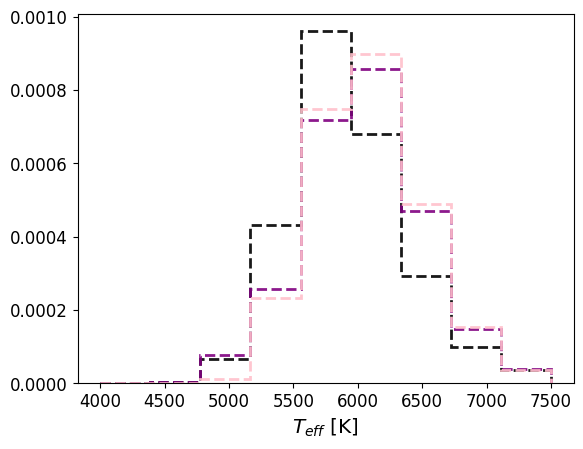

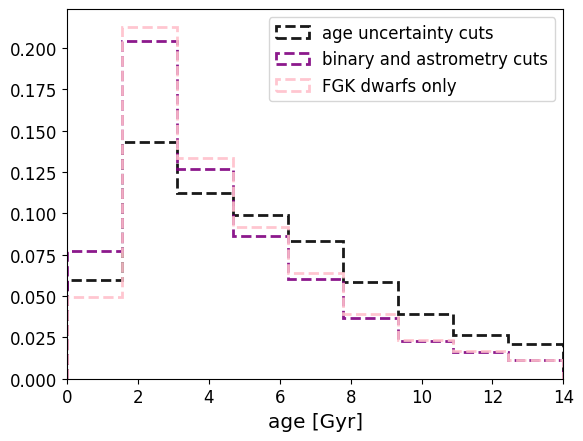

In [87]:
### compare Teff and age for the last three cuts
teff_bins = np.linspace(4000, 7500, 10)
plt.hist(table2.iso_teff, bins=teff_bins, density=True, linestyle='--', linewidth=2, histtype='step', color='k', alpha=0.9, label='age uncertainty cuts')
plt.hist(catalog.iso_teff, bins=teff_bins, density=True, linestyle='--', linewidth=2, histtype='step', color='purple', alpha=0.9, label='binary and astrometry cuts')
plt.hist(kepler_stars_temp.iso_teff, bins=teff_bins, density=True, linestyle='--', linewidth=2, histtype='step', color='pink', alpha=0.9, label='FGK dwarfs only')
plt.xlabel(r"$T_{eff}$ [K]")
plt.savefig(path+'plots/k2/stellar_cuts_teff_kepler.png')
plt.show()

age_bins = np.linspace(0, 14, 10)
plt.hist(table2.iso_age, bins=age_bins, density=True, linestyle='--', linewidth=2, histtype='step', color='k', alpha=0.9, label='age uncertainty cuts')
plt.hist(catalog.iso_age, bins=age_bins, density=True, linestyle='--', linewidth=2, histtype='step', color='purple', alpha=0.9, label='binary and astrometry cuts')
plt.hist(kepler_stars_temp.iso_age, bins=age_bins, density=True, linestyle='--', linewidth=2, histtype='step', color='pink', alpha=0.9, label='FGK dwarfs only')
plt.xlabel("age [Gyr]")
plt.xlim([0, 14])
plt.legend()
plt.savefig(path+'plots/k2/stellar_cuts_age_kepler.png')
plt.show()

#### Kiel diagram (final)

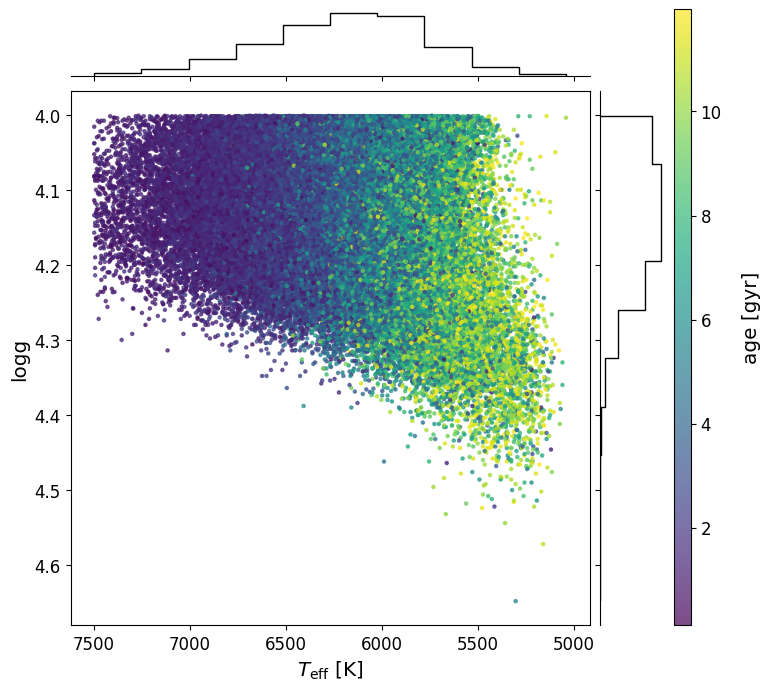

In [377]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 3, figure=fig, wspace=0.05, hspace=0.05, width_ratios=[8, 1, 0.25], height_ratios=[1, 8]) # two horizontal assets, but third vertical asset required for colorbar

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1, 0])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.00, pos.width, pos.height])
ax_histx.set_yticks([])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_histy.set_xticks([])

im = ax_scatter.scatter(kepler_stars_bootstrapped['Teff'], kepler_stars_bootstrapped['logg'], s=5, alpha=0.7, c=kepler_stars_bootstrapped['age'])

# histograms
ax_histx.hist(kepler_stars_bootstrapped['Teff'], bins=10, histtype='step', color="k", linewidth=1)
ax_histy.hist(kepler_stars_bootstrapped['logg'], bins=10, orientation='horizontal', histtype='step', color="k", linewidth=1)
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
#ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

# add colorbar as final asset
ax_cbar = fig.add_subplot(gs[:, 2])

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
#ax_scatter.set_xlim([7600, 3900])
#ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label='age [Gyr]')
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.set_label('age [gyr]', labelpad=15)
cbar.ax.yaxis.set_label_position("right")
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_b20_kepler.png')
plt.show()

#### Draw Zmax

In [378]:
kepler_stars_bootstrapped['height'] = simulate_helpers.gala_galactic_heights(Table.from_pandas(kepler_stars_bootstrapped))
kepler_stars_bootstrapped['height']

100%|██████████| 79343/79343 [07:30<00:00, 176.05it/s]


19       0.313730
29       0.104921
30       0.110491
31       0.129173
32       0.244984
           ...   
60366    0.546254
60367    0.682110
60380    0.286546
60384    0.981505
60385    0.769749
Name: height, Length: 79343, dtype: float64

#### Read out data

In [379]:
kepler_stars_bootstrapped.to_csv(path+'data/kepler/kepler_stars_bootstrapped.csv', index=False)

#### Cross-match with Bedell Gaia-Kepler cross-match in order to introduce kepmag

In [395]:
kepler_stars_bedell_df_kepmag = pd.merge(kepler_stars_bootstrapped, bedell_df[['kepid', 'kepmag']], left_on='KIC', right_on='kepid') # just for matched sampling
print(len(kepler_stars_bedell_df_kepmag))

79343


#### Height vs age

19       7.328283
29       1.419192
30       3.126263
31       7.459596
32       5.752525
           ...   
60366    1.813131
60367    5.489899
60380    3.388889
60384    6.934343
60385    4.176768
Name: age, Length: 79343, dtype: float64
19       313.729898
29       104.920798
30       110.490962
31       129.172528
32       244.984351
            ...    
60366    546.253762
60367    682.109762
60380    286.545583
60384    981.504511
60385    769.748612
Name: height, Length: 79343, dtype: float64


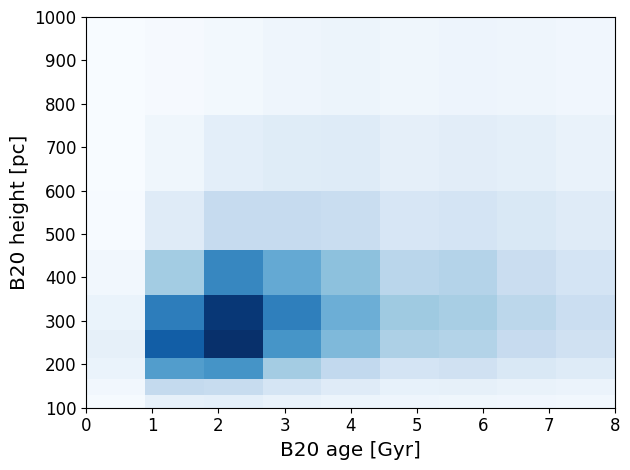

In [380]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='B20'
ages = kepler_stars_bootstrapped['age']
heights = kepler_stars_bootstrapped['height']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B20':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B20 age [Gyr]')
	plt.ylabel('B20 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_B20_bootstrapped.png')
plt.show()

1         4.05
5         1.81
9        10.09
10        4.83
11        2.08
         ...  
60372     3.91
60374     6.67
60375     1.97
60380     4.18
60385     6.93
Name: age, Length: 186912, dtype: float64
1        104.009650
5        221.522715
9        287.551811
10       151.916009
11       396.679770
            ...    
60372    389.243794
60374    604.631828
60375    275.204964
60380    287.457853
60385    778.461353
Name: height, Length: 186912, dtype: float64


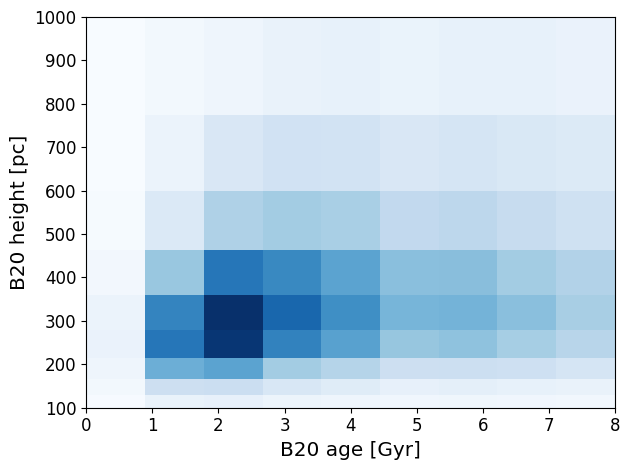

In [341]:
kepler_stars_bootstrapped_logg = kepler_stars_bootstrapped.loc[(kepler_stars_bootstrapped['logg']<4.7) & (kepler_stars_bootstrapped['logg']>4.0)]

bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='B20'
ages = kepler_stars_bootstrapped_logg['age']
heights = kepler_stars_bootstrapped_logg['height']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B20':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B20 age [Gyr]')
	plt.ylabel('B20 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_B20_bootstrapped_logg.png')
plt.show()

### TRILEGAL, Luke's

In [23]:
stem = 'data/kepler/trilegal/luke/' 
filenames = os.listdir(path+stem)

tri_kepler = pd.DataFrame()
for i in range(len(filenames)):

	#temp_k2 = pd.read_csv(path+stem+f'{i+1}.dat.txt', sep='\s+')
	temp_kepler = pd.read_csv(path+stem+filenames[i], sep='\s+')
	temp_kepler.dropna(subset=['logAge','m2/m1'], inplace=True)

	# remove end lines from TRILEGAL, if applicable
	try:
		temp_kepler = temp_kepler[~temp_kepler['logAge'].str.contains('normally', na=False)]
	except:
		pass

	# add height column, introducing a spread of 0.05 dex based on TRILEGAL distance modulus bin size
	temp_kepler['distance'] = simulate_helpers.distance_modulus_to_distance(temp_k2['m-M0'], perturb=True)
	temp_kepler['height'] = simulate_helpers.dist_kepler_to_height(temp_k2['distance'])

	tri_kepler = pd.concat([tri_kepler, temp_kepler])

# remove binaries
tri_kepler = tri_kepler[tri_kepler['m2/m1']==0]
print(len(tri_kepler))

# unlog Teff. keep FGK dwarfs only
tri_kepler['Teff'] = 10**tri_kepler['logTe'].astype(float)
#tri_kepler = tri_kepler.loc[(tri_kepler['Teff'] <= 6500) & (tri_kepler['Teff'] >= 5300)] # keep only F and G dwarfs, pre-Kraft break
tri_kepler = tri_kepler.loc[(tri_kepler['Teff'] <= 6500) & (tri_kepler['Teff'] >= 4000)] # keep only F and G dwarfs, pre-Kraft break
print(len(tri_kepler))

# TRILEGAL logAge bin size is 0.02, so let's introduce a spread of that size; note from Luke Bouma (https://github.com/lgbouma/gyrojo/blob/main/gyrojo/trilegal.py#L92-L108)
eps = np.random.normal(loc=0, scale=0.02, size=len(tri_kepler))
tri_kepler['logAge'] = tri_kepler['logAge'].astype(float)
tri_kepler['logAge'] += eps
tri_kepler['age'] = 10**tri_kepler['logAge'].astype(float) / 1e9

# age cut for uniformity
tri_kepler = tri_kepler.loc[tri_kepler['age'] <= 8.]
print(len(tri_kepler))

# remove poofy stars
tri_kepler = tri_kepler.loc[(tri_kepler['logg']<4.7) & (tri_kepler['logg']>3.6)]

# calculate stellar radius
tri_kepler['stellar_radius'] = simulate_helpers.stellar_radius_stefan_boltzmann(10**tri_kepler['logTe'], 10**tri_kepler['logL'])

# extrapolate CDPP based on Zink+20
#my_k2 = simulate_helpers.kepmag_to_cdpp_vectorized(k2_stars, my_k2) # cdpp distribution is similar to B20 sample

tri_kepler = tri_kepler.reset_index()
tri_kepler


70891
59353
53132


,index,Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,...,r,i,z,DDO51_finf,Mact,distance,height,Teff,age,stellar_radius
0,0,1,6.621414,-0.11,1.01016,-0.112,3.755,4.523,10.30,0.035,...,15.269,15.144,15.112,15.577,1.010,2771.337785,634.749533,5688.529308,0.004182,0.907165
1,5,1,6.804422,0.13,1.19879,0.210,3.785,4.394,11.05,0.037,...,15.190,15.113,15.120,15.424,1.199,763.730583,187.167525,6095.368972,0.006374,1.144685
2,13,1,7.047305,-0.35,0.79361,-0.514,3.712,4.646,7.55,0.019,...,13.571,13.376,13.290,14.040,0.794,2440.018088,574.729975,5152.286446,0.011151,0.696123
3,17,1,7.115909,0.07,1.06969,-0.036,3.759,4.487,10.15,0.034,...,14.911,14.795,14.771,15.220,1.070,888.699098,211.560559,5741.164622,0.013059,0.972045
4,23,1,7.170127,-0.03,0.87306,-0.433,3.711,4.602,7.30,0.018,...,13.101,12.909,12.824,13.614,0.873,1863.215404,423.922864,5140.436516,0.014795,0.767691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43236,27736,1,9.900601,-0.17,0.93349,0.002,3.763,4.406,11.10,0.037,...,15.789,15.675,15.651,16.066,0.933,1591.834154,380.238500,5794.286964,7.954280,0.996979
43237,27768,1,9.892935,-0.13,1.07002,0.462,3.769,4.026,11.70,0.037,...,15.235,15.130,15.113,15.490,1.070,1983.889128,487.197848,5874.893525,7.815103,1.646972
43238,27789,1,9.900334,-0.09,1.08967,0.469,3.731,3.875,11.85,0.038,...,15.386,15.223,15.160,15.762,1.090,2387.418875,555.961191,5382.697825,7.949387,1.977817
43239,27801,1,9.896083,-0.07,1.05572,0.396,3.770,4.092,12.15,0.038,...,15.845,15.743,15.728,16.101,1.056,2702.198310,659.319756,5888.436554,7.871962,1.519449


In [24]:
def matched_sampling(reference_df, sample_df):

    sample_df['iso_teff'] = sample_df['Teff']
    sample_df['iso_logg'] = sample_df['logg']
    sample_df['kepmag'] = sample_df['Kepler']
    
    # normalize variables
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_sample = scaler.fit_transform(sample_df[['iso_teff','iso_logg','kepmag']])
    X_ref    = scaler.transform(reference_df[['iso_teff','iso_logg','kepmag']])

    # fit nearest-neighbor index
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=10) # draw 10x the size of B23 K2  
    nn.fit(X_sample)

    # query neighbors for each reference star
    dist, idx = nn.kneighbors(X_ref)
    matched_idx = idx.flatten()  
    matched_sample = sample_df.iloc[matched_idx]

    return matched_sample

tri_matched_to_b23_kepler = matched_sampling(kepler_stars, tri_kepler)

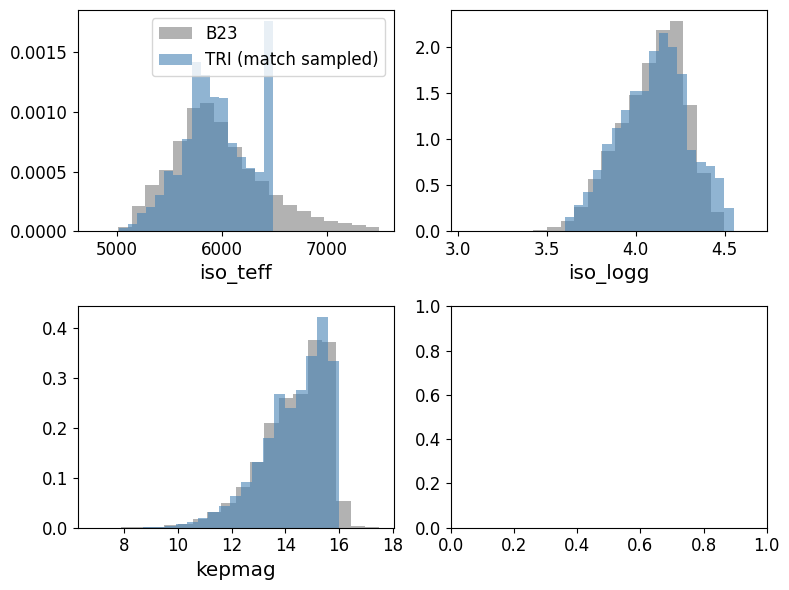

### TRILEGAL, ours

Using Luke's parameters: l=76.32, b=13.5, field area 10deg2, Kepler band photometric system, limiting magnitude in 1st filter 16th mag, distance mod resoultion 0.05 mag, default IMF, binaries 0.5 (only deviation, per Offner+2025, recommended by referee), default extinction, solar positions at R=8122, z=20.8 pc, thin disk SFR given by 2 step SFR + Fuhrman's AMR + alpha-enhanced with age(yr) = 0.735*t + 0, default thick disk, no halo and no bulge stars

Link: https://stev.oapd.inaf.it/cgi-bin/trilegal_1.6

In [ ]:
stem = 'data/kepler/trilegal/' 
filenames = os.listdir(path+stem)
filenames = [item for item in filenames if '.txt' in item] # omit directory name "luke"

tri_kepler = pd.DataFrame()
for i in range(len(filenames)):

	temp_kepler = pd.read_csv(path+stem+filenames[i], sep='\s+')
	temp_kepler.dropna(subset=['logAge','m2/m1'], inplace=True)

	# remove end lines from TRILEGAL, if applicable
	try:
		temp_kepler = temp_kepler[~temp_kepler['logAge'].str.contains('normally', na=False)]
	except:
		pass

	# add height column, introducing a spread of 0.05 dex based on TRILEGAL distance modulus bin size
	temp_kepler['distance'] = simulate_helpers.distance_modulus_to_distance(temp_kepler['m-M0'], perturb=True)
	temp_kepler['height'] = simulate_helpers.dist_kepler_to_height(temp_kepler['distance'])

	tri_kepler = pd.concat([tri_kepler, temp_kepler])

print("initial TRI: ", len(tri_kepler))

# remove binaries
tri_kepler = tri_kepler[tri_kepler['m2/m1']==0]
print("cut binaries: ", len(tri_kepler))

# unlog Teff. keep FGK dwarfs only
tri_kepler['Teff'] = 10**tri_kepler['logTe'].astype(float)
#tri_kepler = tri_kepler.loc[(tri_kepler['Teff'] <= 7500) & (tri_kepler['Teff'] >= 3900)] 
tri_kepler = tri_kepler.loc[(tri_kepler['Teff'] <= np.max(kepler_stars_bootstrapped['Teff'])) & (tri_kepler['Teff'] >= np.min(kepler_stars_bootstrapped['Teff']))] # match B20
print("Teff cut: ", len(tri_kepler))
print("max Teff: ", np.max(kepler_stars_bootstrapped['Teff']))
print("min Teff: ", np.min(kepler_stars_bootstrapped['Teff']))

# calculate stellar radius
tri_kepler['stellar_radius'] = simulate_helpers.stellar_radius_stefan_boltzmann(10**tri_kepler['logTe'], 10**tri_kepler['logL'])

# remove giant based on B20 prescription
tri_kepler['logR'] = np.log10(tri_kepler['stellar_radius'])
tri_kepler['is_giant'] = np.where(tri_kepler['logR'] >= 0.00035*(tri_kepler['Teff'] - 4500) + 0.15, True, False)
tri_kepler = tri_kepler.loc[tri_kepler['is_giant'] == False]
print("cut giants: ", len(tri_kepler))

# remove poofy stars, same as B20
#tri_kepler = tri_kepler.loc[(tri_kepler['logg']<4.7) & (tri_kepler['logg']>3.6)]
tri_kepler = tri_kepler.loc[(tri_kepler['logg']<4.7) & (tri_kepler['logg']>4.)]
print("logg cut: ", len(tri_kepler))

# TRILEGAL logAge bin size is 0.02, so let's introduce a spread of that size; note from Luke Bouma (https://github.com/lgbouma/gyrojo/blob/main/gyrojo/trilegal.py#L92-L108)
eps = np.random.normal(loc=0, scale=0.02, size=len(tri_kepler))
tri_kepler['logAge'] = tri_kepler['logAge'].astype(float)
tri_kepler['logAge'] += eps
tri_kepler['age'] = 10**tri_kepler['logAge'].astype(float) / 1e9

# remove possible PMS stars
#tri_kepler = tri_kepler.loc[tri_kepler['age']>0.5]

# get rid of low metallicity stars because their Teff-logg relation is different
#tri_kepler = tri_kepler.loc[tri_kepler['[M/H]'].astype(float)>=-0.6] # this is different from Fe/H cut for B20, but we only have apples v oranges
#tri_kepler = tri_kepler.loc[tri_kepler['[M/H]'].astype(float)<=0.3] # this is different from Fe/H cut for B20, but we only have apples v oranges
tri_kepler = tri_kepler.loc[tri_kepler['[M/H]'].astype(float)>=-0.25] # this is different from Fe/H cut for B20, but we only have apples v oranges
tri_kepler = tri_kepler.loc[tri_kepler['[M/H]'].astype(float)<=0.25]
print("metallicity cut: ", len(tri_kepler))

# same age cut as B20
tri_kepler = tri_kepler.loc[tri_kepler['age'] <= 12.] 
print("age cut: ", len(tri_kepler))

# make an additional cut on Kepler magnitude
tri_kepler = tri_kepler.loc[(tri_kepler['Kepler'] <= np.max(kepler_stars_bedell_df_kepmag['kepmag'])) & (tri_kepler['Kepler'] >= np.min(kepler_stars_bedell_df_kepmag['kepmag']))] 
print("kepmag cut: ", len(tri_kepler))
print("min kepmag: ", np.min(kepler_stars_bedell_df_kepmag['kepmag']))
print("max kepmag: ", np.max(kepler_stars_bedell_df_kepmag['kepmag']))

# extrapolate CDPP based on Zink+20
#my_k2 = simulate_helpers.kepmag_to_cdpp_vectorized(k2_stars, my_k2) # cdpp distribution is similar to B20 sample

tri_kepler = tri_kepler.reset_index()
tri_kepler


initial TRI:  280647
cut binaries:  132951
Teff cut:  101326
max Teff:  7498.0980980980985
min Teff:  5039.239239239239
cut giants:  97712
logg cut:  82177
metallicity cut:  54599
age cut:  54599
kepmag cut:  25051
min kepmag:  7.017
max kepmag:  14.961


,index,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,...,H,Ks,Mact,distance,height,Teff,stellar_radius,logR,is_giant,age
0,5,1,6.813116,0.23,1.64992,0.841,3.870,4.242,10.519991,0.035,...,12.458,12.436,1.650,1270.568887,296.608416,7413.102413,1.600244,0.204186,False,0.006503
1,60,1,7.512502,0.07,1.33028,0.450,3.817,4.325,11.098573,0.037,...,13.798,13.770,1.330,1658.496524,387.168325,6561.452663,1.302225,0.114686,False,0.032546
2,64,1,7.533963,0.15,1.36001,0.478,3.817,4.307,9.800895,0.033,...,12.327,12.299,1.360,912.386748,212.992456,6561.452663,1.344888,0.128686,False,0.034195
3,65,1,7.500747,0.23,1.09258,-0.006,3.758,4.461,7.346701,0.018,...,10.626,10.582,1.093,294.672841,68.790009,5727.960310,1.010849,0.004686,False,0.031677
4,76,1,7.548561,-0.01,1.30719,0.434,3.818,4.337,10.097010,0.034,...,12.645,12.618,1.307,1045.687518,244.110903,6576.578374,1.272583,0.104686,False,0.035364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25046,30247,1,9.887223,-0.13,1.03667,0.344,3.774,4.153,10.435834,0.035,...,12.971,12.933,1.037,1222.268929,285.333015,5942.921586,1.405032,0.147686,False,7.712996
25047,30266,1,9.900853,-0.11,1.05239,0.394,3.774,4.107,9.730404,0.032,...,12.141,12.102,1.052,883.244305,206.189288,5942.921586,1.488285,0.172686,False,7.958895
25048,30284,1,9.938930,-0.09,1.03033,0.311,3.771,4.171,10.020433,0.034,...,12.680,12.641,1.030,1009.454049,235.652368,5902.010802,1.371470,0.137186,False,8.688194
25049,30285,1,9.903309,-0.09,1.02015,0.275,3.771,4.200,10.828289,0.036,...,13.517,13.477,1.020,1464.393261,341.855818,5902.010802,1.315789,0.119186,False,8.004042


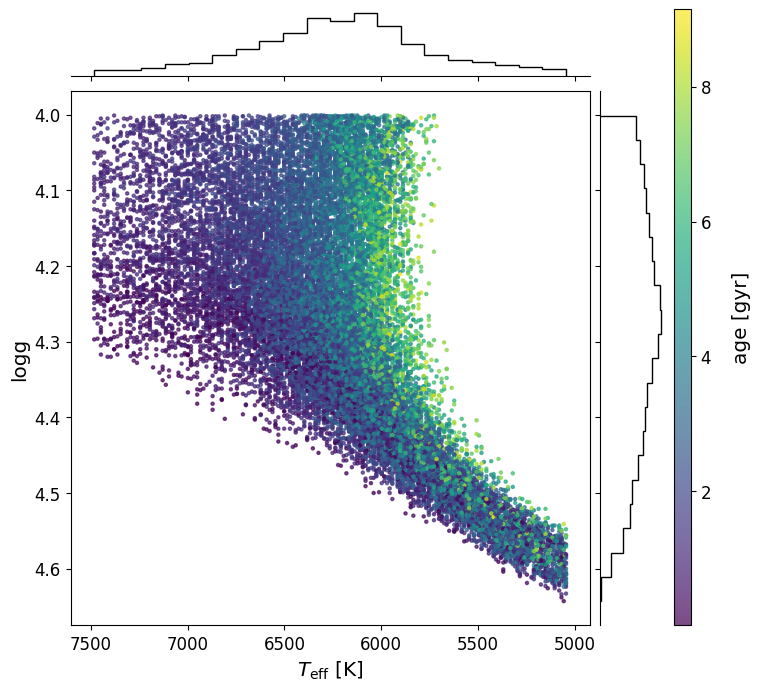

In [412]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 3, figure=fig, wspace=0.05, hspace=0.05, width_ratios=[8, 1, 0.25], height_ratios=[1, 8]) # two horizontal assets, but third vertical asset required for colorbar

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1, 0])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.00, pos.width, pos.height])
ax_histx.set_yticks([])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_histy.set_xticks([])
im = ax_scatter.scatter(tri_kepler['Teff'], tri_kepler['logg'], s=5, alpha=0.7, c=tri_kepler['age'])

# histograms
ax_histx.hist(tri_kepler['Teff'], bins=20, histtype='step', color="k", linewidth=1)
ax_histy.hist(tri_kepler['logg'], bins=20, orientation='horizontal', histtype='step', color="k", linewidth=1)
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
#ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

# add colorbar as final asset
ax_cbar = fig.add_subplot(gs[:, 2])

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
#ax_scatter.set_xlim([7600, 3900])
#ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label='age [Gyr]')
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.set_label('age [gyr]', labelpad=15)
cbar.ax.yaxis.set_label_position("right")
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_tri_kepler.png')
plt.show()

#### Matched sampling

I forgot to include kepmag from bedell_df

In [314]:
kepler_stars_bedell_df_kepmag = pd.merge(kepler_stars_bootstrapped_age, bedell_df[['kepid', 'kepmag']], left_on='KIC', right_on='kepid') # just for matched sampling
print(len(kepler_stars_bedell_df_kepmag))

243776


In [ ]:
def matched_sampling(reference_df, sample_df):

    sample_df['kepmag'] = sample_df['Kepler']
    
    # normalize variables
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_sample = scaler.fit_transform(sample_df[['Teff','logg','kepmag']])
    X_ref    = scaler.transform(reference_df[['Teff','logg','kepmag']])

    # fit nearest-neighbor inddex
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1) 
    nn.fit(X_sample)

    # query neighbors for each reference star
    dist, idx = nn.kneighbors(X_ref)
    matched_idx = idx.flatten()  
    matched_sample = sample_df.iloc[matched_idx]

    return matched_sample

tri_matched_to_b23_kepler = matched_sampling(kepler_stars_bedell_df_kepmag, tri_kepler_metal)
print(len(tri_matched_to_b23_kepler))



243776


In [328]:
kepler_stars_bedell_df_kepmag_logg = kepler_stars_bedell_df_kepmag.loc[kepler_stars_bedell_df_kepmag['logg']>4.]
print(len(kepler_stars_bedell_df_kepmag_logg))
tri_kepler_metal_logg = tri_kepler_metal.loc[tri_kepler_metal['logg']>4.]
print(len(tri_kepler_metal_logg))
tri_matched_to_b23_kepler_logg = matched_sampling(kepler_stars_bedell_df_kepmag_logg, tri_kepler_metal_logg)
print(len(tri_matched_to_b23_kepler_logg))


150305
58280
150305


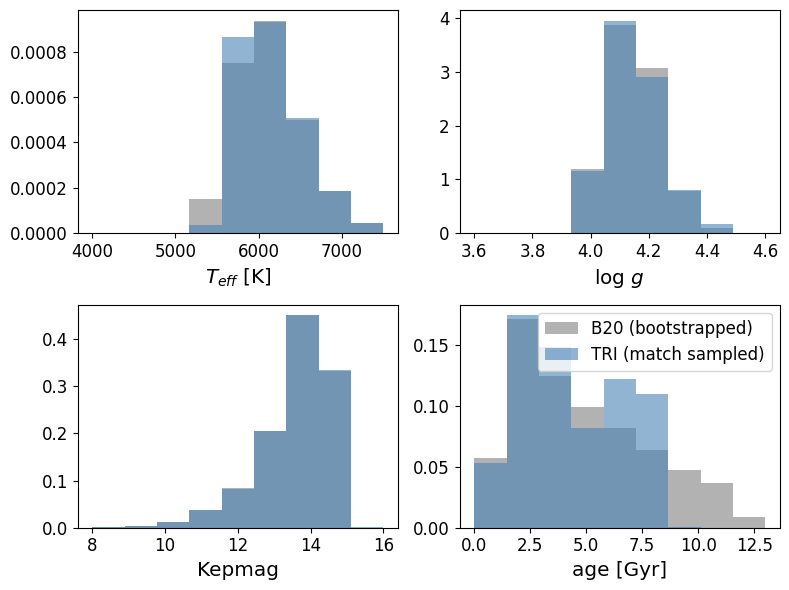

In [329]:
cols = ["iso_teff", "iso_logg", "kepmag", "iso_age"]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

"""
for i, col in enumerate(cols):
    ax = axes[i]

    ax.hist(kepler_stars_bedell_df_kepmag[col], bins=20, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
    #ax.hist(tri_kepler[col], bins=20, alpha=0.6, label="TRI", density=True, color='purple')
    ax.hist(tri_matched_to_b23_kepler[col], bins=20, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')

    ax.set_xlabel(col)
    #ax.set_ylabel()
    if i==3:
        ax.legend(loc='upper right')
"""

ax = axes[0]
teff_bins = np.linspace(4000, 7500, 10)
ax.hist(kepler_stars_bedell_df_kepmag_logg['Teff'], bins=teff_bins, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
#ax.hist(tri_kepler['Teff'], bins=teff_bins, alpha=0.6, label="TRI", density=True, color='purple')
ax.hist(tri_matched_to_b23_kepler_logg['Teff'], bins=teff_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r"$T_{eff}$ [K]")

ax = axes[1]
logg_bins = np.linspace(3.6, 4.6, 10)
ax.hist(kepler_stars_bedell_df_kepmag_logg['logg'], bins=logg_bins, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
#ax.hist(tri_kepler['logg'], bins=logg_bins, alpha=0.6, label="TRI", density=True, color='purple')
ax.hist(tri_matched_to_b23_kepler_logg['logg'], bins=logg_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'log $g$')

ax = axes[2]
kepmag_bins = np.linspace(8, 16, 10)
ax.hist(kepler_stars_bedell_df_kepmag_logg['kepmag'], bins=kepmag_bins, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
#ax.hist(tri_kepler['kepmag'], bins=kepmag_bins, alpha=0.6, label="TRI", density=True, color='purple')
ax.hist(tri_matched_to_b23_kepler_logg['kepmag'], bins=kepmag_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'Kepmag')

ax = axes[3]
age_bins = np.linspace(0, 13, 10)
ax.hist(kepler_stars_bedell_df_kepmag_logg['age'], bins=age_bins, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
#ax.hist(tri_kepler['age'], bins=age_bins, alpha=0.6, label="TRI", density=True, color='purple')
ax.hist(tri_matched_to_b23_kepler_logg['age'], bins=age_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'age [Gyr]')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(path+'plots/k2/matched_sampling_params2.png')
plt.show()

65659    6.015199
46897    1.661724
63297    3.934076
71922    3.600802
14254    3.476393
           ...   
61328    2.557841
56838    7.906618
721      1.054612
37402    2.964665
84262    4.136844
Name: age, Length: 150305, dtype: float64
65659    140.162112
46897    287.240516
63297    258.269304
71922    206.931733
14254    197.193513
            ...    
61328    300.341216
56838    341.751110
721      201.049926
37402    230.767994
84262    142.962401
Name: height, Length: 150305, dtype: float64


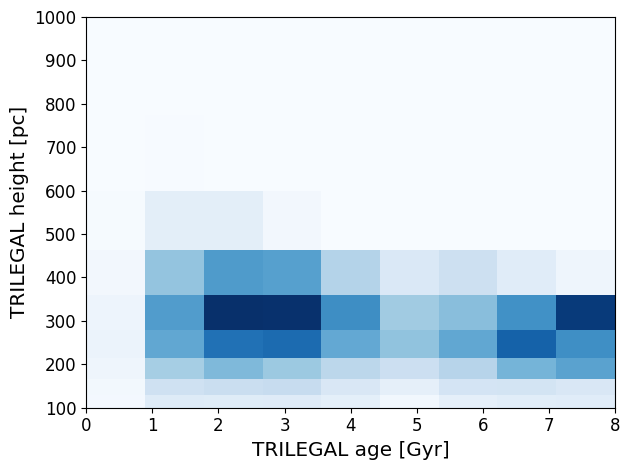

In [331]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = tri_matched_to_b23_kepler_logg['age']
heights = tri_matched_to_b23_kepler_logg['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B20':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B20 age [Gyr]')
	plt.ylabel('B20 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_tri_kepler_bootstrapped.png')
plt.show()

0        0.006605
1        0.007774
2        0.009980
4        0.009716
6        0.013662
           ...   
98421    8.746113
98422    7.934313
98423    8.209454
98424    8.467551
98425    8.212078
Name: age, Length: 68219, dtype: float64
0        295.007280
1        248.637846
2        506.902834
4        292.705177
6        233.377577
            ...    
98421    431.903198
98422    368.660437
98423    483.532401
98424    403.594015
98425    540.048430
Name: height, Length: 68219, dtype: float64


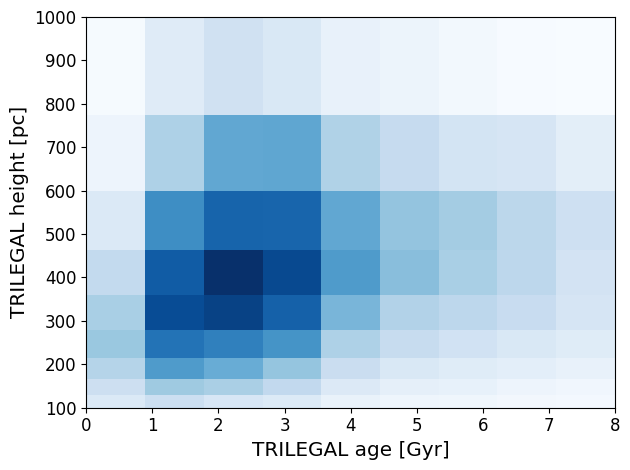

In [306]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = tri_kepler_metal['age']
heights = tri_kepler_metal['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B20':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B20 age [Gyr]')
	plt.ylabel('B20 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
#plt.savefig(path+'plots/k2/age_vs_height_tri_kepler_bootstrapped.png')
plt.show()

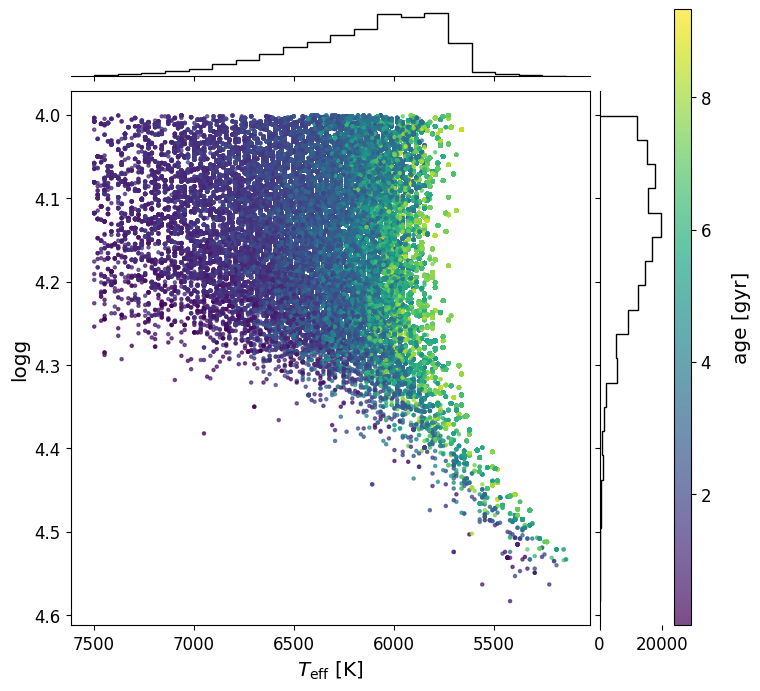

In [332]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 3, figure=fig, wspace=0.05, hspace=0.05, width_ratios=[8, 1, 0.25], height_ratios=[1, 8]) # two horizontal assets, but third vertical asset required for colorbar

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1, 0])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.00, pos.width, pos.height])
ax_histx.set_yticks([])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

im = ax_scatter.scatter(tri_matched_to_b23_kepler_logg['Teff'], tri_matched_to_b23_kepler_logg['logg'], s=5, alpha=0.7, c=tri_matched_to_b23_kepler_logg['age'])

# histograms
ax_histx.hist(tri_matched_to_b23_kepler_logg['Teff'], bins=20, histtype='step', color="k", linewidth=1)
ax_histy.hist(tri_matched_to_b23_kepler_logg['logg'], bins=20, orientation='horizontal', histtype='step', color="k", linewidth=1)
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
#ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

# add colorbar as final asset
ax_cbar = fig.add_subplot(gs[:, 2])

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
#ax_scatter.set_xlim([7600, 3900])
#ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label='age [Gyr]')
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.set_label('age [gyr]', labelpad=15)
cbar.ax.yaxis.set_label_position("right")
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_tri_kepler.png')
plt.show()

In [333]:
tri_matched_to_b23_kepler_logg

,index,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,...,Ks,Mact,distance,height,Teff,age,stellar_radius,logR,is_giant,kepmag
65659,25868,1,9.779250,0.21,0.96314,-0.095,3.740,4.424,8.892227,0.028,...,12.280,0.963,600.406491,140.162112,5495.408739,6.015199,0.991257,-0.003814,False,13.882
46897,4830,1,9.220559,0.25,1.52526,0.802,3.818,4.038,10.450302,0.035,...,NaN,1.525,1230.440010,287.240516,6576.578374,1.661724,1.943955,0.288686,False,13.162
63297,16993,1,9.594843,0.15,1.22190,0.420,3.774,4.146,10.219438,0.034,...,12.533,1.222,1106.337260,258.269304,5942.921586,3.934076,1.533508,0.185686,False,13.876
71922,14616,1,9.556399,0.21,1.24876,0.440,3.778,4.153,9.738209,0.032,...,12.014,1.249,886.424683,206.931733,5997.910763,3.600802,1.540587,0.187686,False,13.319
14254,14492,1,9.541129,0.01,1.23403,0.483,3.790,4.154,9.633537,0.032,...,11.948,1.234,844.709487,197.193513,6165.950019,3.476393,1.531744,0.185186,False,13.176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61328,11013,1,9.407873,0.13,1.32200,0.566,3.792,4.109,10.547148,0.036,...,12.703,1.322,1286.558922,300.341216,6194.410751,2.557841,1.669884,0.222686,False,13.911
56838,25926,1,9.897991,0.21,1.06538,0.262,3.758,4.181,10.827623,0.036,...,NaN,1.065,1463.944730,341.751110,5727.960310,7.906618,1.376215,0.138686,False,14.929
721,2537,1,9.023093,0.13,1.61330,0.897,3.850,4.093,9.675593,0.032,...,11.294,1.613,861.229039,201.049926,7079.457844,1.054612,1.871484,0.272186,False,12.097
37402,11321,1,9.471976,0.03,1.26762,0.520,3.795,4.148,9.974952,0.033,...,NaN,1.268,988.531063,230.767994,6237.348355,2.964665,1.562019,0.193686,False,13.332


1          4.05
3          1.81
5         10.09
6          4.83
7          2.08
          ...  
243767     4.31
243768     3.91
243770     1.97
243772     4.18
243775     6.93
Name: age, Length: 150305, dtype: float64
1         104.009650
3         221.522715
5         287.551811
6         151.916009
7         396.679770
             ...    
243767    689.469088
243768    389.243794
243770    275.204964
243772    287.457853
243775    778.461353
Name: height, Length: 150305, dtype: float64


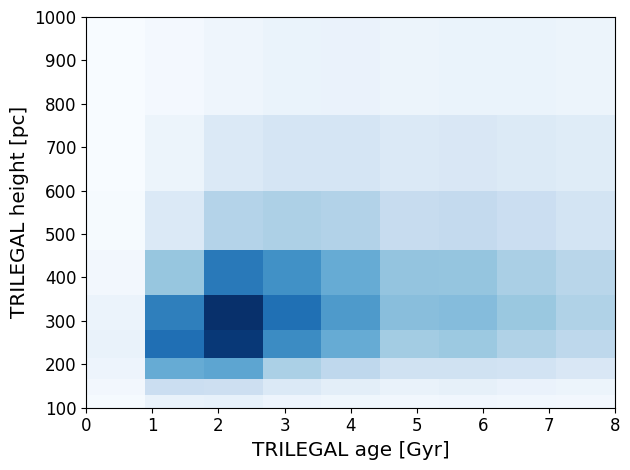

In [335]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = kepler_stars_bedell_df_kepmag_logg['age']
heights = kepler_stars_bedell_df_kepmag_logg['height']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B20':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B20 age [Gyr]')
	plt.ylabel('B20 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
#plt.savefig(path+'plots/k2/age_vs_height_tri_kepler_bootstrapped.png')
plt.show()

It looks like matched sampling is doing too much. What about a more basic set of cuts?

#### Basic cuts

Why do lot work for confusion when no work do trick?

In [ ]:
"""
tri_kepler_metal_cuts = tri_kepler_metal.loc[(tri_kepler_metal['logg']<4.7) & (tri_kepler_metal['logg']>4.0) &
											 (tri_kepler_metal['kepmag']<np.max(kepler_stars_bedell_df_kepmag_logg['kepmag'])) & 
											 (tri_kepler_metal['kepmag']>np.min(kepler_stars_bedell_df_kepmag_logg['kepmag'])) &
											 (tri_kepler_metal['Teff']<np.max(kepler_stars_bedell_df_kepmag_logg['Teff'])) &
											 (tri_kepler_metal['Teff']>np.min(kepler_stars_bedell_df_kepmag_logg['Teff']))]
"""

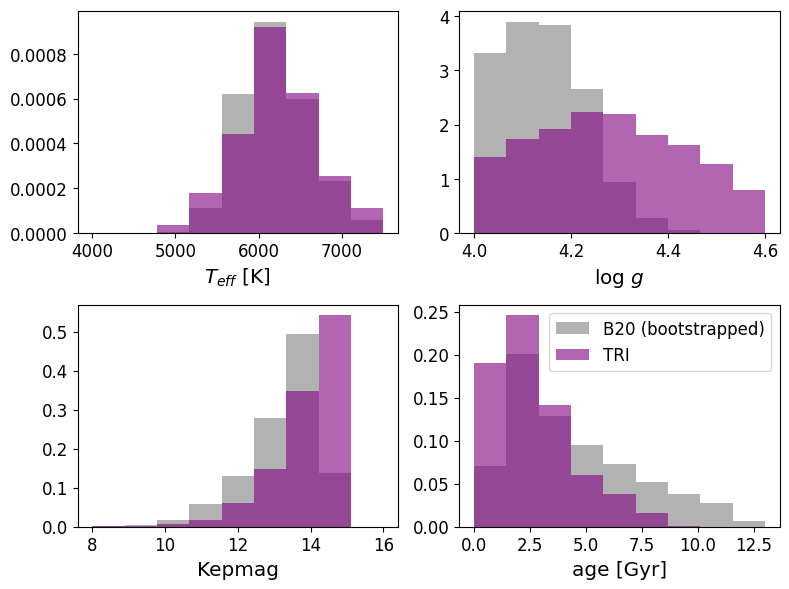

In [409]:
cols = ["iso_teff", "iso_logg", "kepmag", "iso_age"]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

"""
for i, col in enumerate(cols):
    ax = axes[i]

    ax.hist(kepler_stars_bedell_df_kepmag[col], bins=20, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
    #ax.hist(tri_kepler[col], bins=20, alpha=0.6, label="TRI", density=True, color='purple')
    ax.hist(tri_matched_to_b23_kepler[col], bins=20, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')

    ax.set_xlabel(col)
    #ax.set_ylabel()
    if i==3:
        ax.legend(loc='upper right')
"""

ax = axes[0]
teff_bins = np.linspace(4000, 7500, 10)
ax.hist(kepler_stars_bedell_df_kepmag['Teff'], bins=teff_bins, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
ax.hist(tri_kepler['Teff'], bins=teff_bins, alpha=0.6, label="TRI", density=True, color='purple')
#ax.hist(tri_matched_to_b23_kepler_logg['Teff'], bins=teff_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r"$T_{eff}$ [K]")

ax = axes[1]
logg_bins = np.linspace(4., 4.6, 10)
ax.hist(kepler_stars_bedell_df_kepmag['logg'], bins=logg_bins, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
ax.hist(tri_kepler['logg'], bins=logg_bins, alpha=0.6, label="TRI", density=True, color='purple')
#ax.hist(tri_matched_to_b23_kepler_logg['logg'], bins=logg_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'log $g$')

ax = axes[2]
kepmag_bins = np.linspace(8, 16, 10)
ax.hist(kepler_stars_bedell_df_kepmag['kepmag'], bins=kepmag_bins, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
ax.hist(tri_kepler['Kepler'], bins=kepmag_bins, alpha=0.6, label="TRI", density=True, color='purple')
#ax.hist(tri_matched_to_b23_kepler_logg['kepmag'], bins=kepmag_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'Kepmag')

ax = axes[3]
age_bins = np.linspace(0, 13, 10)
ax.hist(kepler_stars_bedell_df_kepmag['age'], bins=age_bins, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
ax.hist(tri_kepler['age'], bins=age_bins, alpha=0.6, label="TRI", density=True, color='purple')
#ax.hist(tri_matched_to_b23_kepler_logg['age'], bins=age_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'age [Gyr]')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(path+'plots/k2/tri_vs_b20_params.png')
plt.show()

0        0.006423
1        0.031100
2        0.032852
3        0.034484
4        0.039727
           ...   
25046    8.760839
25047    9.080133
25048    7.980822
25049    8.317986
25050    7.672862
Name: age, Length: 25051, dtype: float64
0        284.988901
1        411.925144
2        218.408503
3         68.216760
4        236.788975
            ...    
25046    285.675929
25047    201.524047
25048    235.552177
25049    337.591960
25050    150.758679
Name: height, Length: 25051, dtype: float64


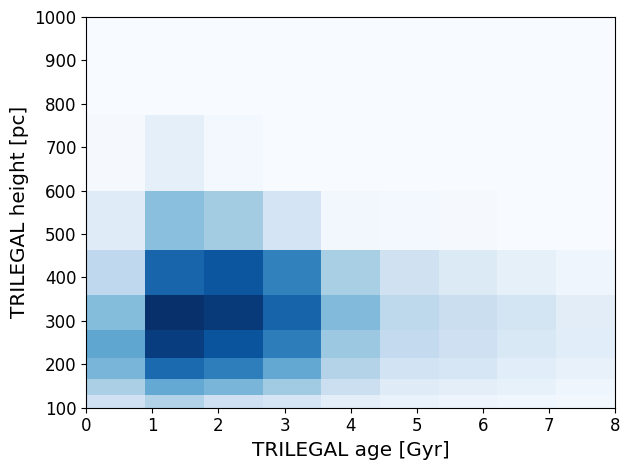

In [410]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = tri_kepler['age']
heights = tri_kepler['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B20':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B20 age [Gyr]')
	plt.ylabel('B20 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_tri_kepler_bootstrapped.png')
plt.show()

#### Compare TRI and B20 heights directly

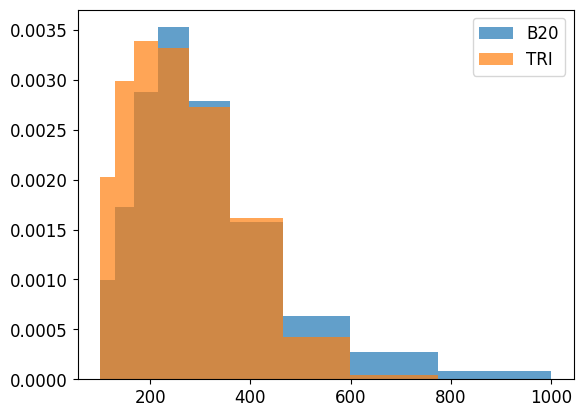

median B20:  291.2165578775075
median TRI:  255.6187179743924
mean B20:  334.0697645304657
mean TRI:  267.7318033416101


In [415]:
plt.hist(kepler_stars_bootstrapped['height']*1000, density=True, bins=np.logspace(2,3,10), alpha=0.7, label='B20')
plt.hist(tri_kepler['height'], density=True, bins=np.logspace(2,3,10), alpha=0.7, label='TRI')
plt.legend()
plt.show()

print("median B20: ", np.median(kepler_stars_bootstrapped['height']*1000))
print("median TRI: ", np.median(tri_kepler['height']))
print("mean B20: ", np.mean(kepler_stars_bootstrapped['height']*1000))
print("mean TRI: ", np.mean(tri_kepler['height']))

### Time to make planets!